## Klasifikacija radnih mesta<a id="par:toc"></a>

U svesci je razmotrena primena tehnika obrade prirodnih jezika ([*natural language processing*](https://en.wikipedia.org/wiki/Natural_language_processing), *NLP*) na rešavanje problema razvrstavanja radnih mesta ([*job title*](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Occupations)) prema senioritetu. Dostavljeni podaci su učitani i pripremljeni (normalizovani i vektorizovani) na više različitih načina, nakon čega je na delu radnih mesta obučeno nekoliko klasifikacionih modela. Modeli su vrednovani prema ponašanju na drugom delu podataka, odnosno uspešnosti predviđanja senioriteta.

Pored samog koda i rezultata, usput su detaljno prokomentarisani svi preduzeti koraci. Posebno je zanimljivo napomenuti da je primenjeno ponešto karakteristično za svaku od tri faze razvoja obrade prirodnih jezika kao oblasti: simbolički *NLP* (regularni izrazi, klasifikacija prema ručno osmišljenim pravilima i slično), statistički *NLP* (metode mašinskog učenja), neuronski/duboki *NLP* (primena neuronskih mreža i dubokog učenja).

## Sadržaj

1. [Učitavanje podataka](#par:uchit)
2. [Analiza i čišćenje](#par:anchi)
3. [Normalizacija teksta](#par:norm)
4. [Klasifikaciona pravila](#par:prav)
5. [Retka vektorizacija](#par:retk)
6. [Gusta vektorizacija](#par:gust)

## 1. Učitavanje podataka [⮭]<a id="par:uchit"></a>

[⮭]: #par:toc

Za početak, neophodno je učitati dostavljene podatke. Oni se nalaze u pet različitih datoteka, od kojih su prve četiri (`20.txt`, `20-40.txt`, `40-60.txt`, `60-100.txt`) planirane za pravljenje i evaluaciju modela, dok peta (`test_titles.json`) sadrži neobeležena radna mesta i namenjena je proveri klasifikacije potpuno novih, nekategorizovanih i nezavisnih podataka. Sve nabrojane datoteke smeštene su u direktorijum `podaci`.

In [1]:
# Podaci za pravljenje i evaluaciju modela
train_podaci = ['20.txt', '20-40.txt', '40-60.txt', '60-100.txt']

# Dodavanje direktorijuma na imena datoteka
for i, p in enumerate(train_podaci):
    train_podaci[i] = '../podaci/' + p

# Podaci za proveru klasifikacije na kraju
test_podaci = '../podaci/test_titles.json'

Deo podataka planiran za pravljenje i evaluaciju modela dat je u strukturiranom formatu sledećeg oblika.

`{
  name: 'chief financial officer',
  role: 'finance',
  levels: [ 'cxo' ],
  sub_role: null
}`

Na konkretnom primeru, naziv radnog mesta (*name*) jeste [*chief financial officer*](https://en.wikipedia.org/wiki/Chief_financial_officer) (finansijski direktor), uloga/odeljenje (*role*) jeste *finance* (finansije), nivo/senioritet (*levels*) jeste [*cxo*](https://en.wikipedia.org/wiki/Chief_experience_officer) (direktor), dok poduloga (*sub_role*) nije definisana. Na drugim primerima, postoji više nivoa ili nisu definisani.

`{
  name: 'community teaching experience',
  role: null,
  levels: [],
  sub_role: null
}`

`{
  name: 'owner and lead programmer',
  role: 'engineering',
  levels: ['manager', 'owner'],
  sub_role: null
}`

U nastavku je napisana jednostavna klasa koja skladišti podatke prema navedenom šablonu. Može i da ih poredi, kao i lepo da ih odštampa.

In [2]:
# Klasa koja opisuje radno mesto
class JobTitle:
    # Konstruktor koji samo pamti podatke
    def __init__(self, name, role=None, levels=None, sub_role=None):
        self.name = name
        self.role = role
        self.levels = levels
        self.sub_role = sub_role
    
    # Poređenje (<) dva radna mesta
    def __lt__(self, other):
        return self.name < other.name
    
    # Poređenje (==) dva radna mesta
    def __eq__(self, other):
        return self.name == other.name
    
    # Predstavljanje objekta u vidu niske
    def __str__(self):
        return f'{{\n  name: {self.name},\n  role: {self.role},\n  ' \
               f'levels: {self.levels},\n  sub_role: {self.sub_role}\n}}'

Ovaj format liči na poznati [*JSON*](https://en.wikipedia.org/wiki/JSON), ali ipak ne koristi navodnike na pravi način, tako da ga nije moguće učitati koristeći ugrađeni modul `json`. Umesto toga, iskorišćen je modul `re`, odnosno podaci su učitani koristeći [regularne izraze](https://en.wikipedia.org/wiki/Regular_expression). Ovo je u duhu simboličkog *NLP*-ja, kao prve etape u razvoju ove oblasti.

In [3]:
# Modul za rad sa regularnim izrazima
import re

# Funkcija za učitavanje podataka iz datoteke
def učitaj(datoteka):
    # Otvaranje datoteke sa UTF-8 enkodiranjem
    with open(datoteka, encoding='utf-8') as f:
        # Čitanje celog teksta datoteke
        tekst = f.read()
    
    # Regularni izraz koji izdvaja jedno radno mesto
    regex = r'{\s+name: (.+?),\s+role: (.+?),\s+levels: (.+?),\s+sub_role: (.+?)\s+}'
    
    # Inicijalno prazan niz podataka
    podaci = []
    
    # Null iz datoteka je None u Pythonu
    null = None
    
    # Dodavanje svakog radnog mesta iz datoteke
    for name, role, levels, sub_role in re.findall(regex, tekst):
        podaci.append(JobTitle(eval(name), eval(role),
                               eval(levels), eval(sub_role)))
    
    # Vraćanje napunjenog niza podataka
    return podaci

In [4]:
# Inicijalno prazan niz podataka
podaci = []

# Dodavanje radnih mesta iz svake datoteke
for tp in train_podaci:
    podaci.extend(učitaj(tp))

Za kraj učitavanja, može se ispisati nekoliko instanci radnih mesta kako bi bilo jasno da je učitavanje obavljeno kako treba. Odabrane su iste kao gore.

In [5]:
# Ispis prvog podatka; primer sa jednim nivoom
print(podaci[0])

{
  name: chief financial officer,
  role: finance,
  levels: ['cxo'],
  sub_role: None
}


In [6]:
# Ispis petog podatka; primer sa nedostajućim nivoom
print(podaci[4])

{
  name: community teaching experience,
  role: None,
  levels: [],
  sub_role: None
}


In [7]:
# Ispis dvadesetog podatka; primer sa više (dva) nivoa
print(podaci[19])

{
  name: owner and lead programmer,
  role: engineering,
  levels: ['manager', 'owner'],
  sub_role: None
}


Test podaci su u korektnom *JSON* formatu, pa se mogu lakše učitati, uz odgovarajuću bibliotečku podršku.

`[
{"final_title":"Implementation Consultant III"},
...
{"final_title":"Co-Chairman Bridgepoint Emerging Leaders"}
]`

In [8]:
# Modul za rad sa JSON formatom
import json

# Učitavanje test podataka iz datoteke
with open(test_podaci, encoding='utf-8') as f:
    test = json.load(f)

# Ubacivanje učitanih podataka u klasu
test = [JobTitle(t['final_title']) for t in test]

In [9]:
# Ispit broja test podataka
print('Ukupno test podataka:', len(test))

Ukupno test podataka: 40000


In [10]:
# Ispis prvog podatka kao primer
print(test[0])

{
  name: Implementation Consultant III,
  role: None,
  levels: None,
  sub_role: None
}


## 2. Analiza i čišćenje [⮭]<a id="par:anchi"></a>

[⮭]: #par:toc

Korisno je proučiti podatke ([eksploratorna analiza](https://en.wikipedia.org/wiki/Exploratory_data_analysis)) kako bi se stekao uvid u njih pre prelaska na narednu fazu obrade. Primera radi, važno je uočiti da je tek svaki deveti do deseti objekat unikat. Znatno je više učitanih radnih mesta od različitih, što su ona koja imaju različito (jedinstveno) ime.

In [11]:
# Modul za efikasan rad sa nizovima
import numpy as np

# Funkcija za određivanje unikata
unikati = lambda niz: np.unique(niz, return_counts=True)

In [12]:
# Određivanje nereduntantnih podataka
podjed, brjed = unikati(podaci)

# Izveštavanje o ukupom broju instanci
print('Ukupno učitanih radnih mesta:', len(podaci))

# Izveštavanje o broju jedinstvenih instanci
print('Ukupno različitih radnih mesta:', len(podjed))

Ukupno učitanih radnih mesta: 611586
Ukupno različitih radnih mesta: 64815


Daljom analizom može se utvrditi da se više od pola radnih mesta ponavlja. Poželjna je neredundantnost podataka, pa je ponavljanja potrebno odbaciti.

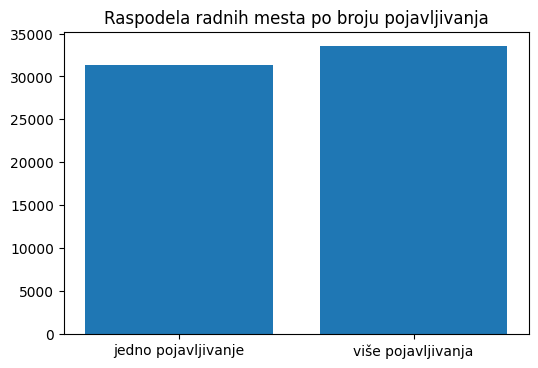

In [13]:
# Modul za grafički prikaz podataka
from matplotlib import pyplot as plt

# Podešavanje modula za prikaz u svesci
%matplotlib inline

# Povećavanje kvaliteta grafikona
plt.rcParams['figure.dpi'] = 100

# Određivanje brojeva ponavljanja
_, j = unikati([b > 1 for b in brjed])

# Predstavljanje raspodele stubićima
plt.bar(['jedno pojavljivanje', 'više pojavljivanja'], j)

# Naslov grafikona
_ = plt.title('Raspodela radnih mesta po broju pojavljivanja')

Dodatno su analizirana i najčešća ponavljanja. Skoro dvadeset hiljada puta ponavljaju se samo tri različite pozicije: [*chief executive officer*](https://en.wikipedia.org/wiki/Chief_executive_officer) (glavni izvršni direktor) sa nivoom *cxo* (direktor), *associate* (saradnik) sa nedostajućim nivoom i *managing director* (upravni direktor) sa nivoom *director* (upravnik).

In [14]:
# Indeksi za sortiranje po broju ponavljanja
indeksi = np.argsort(brjed)

# Sortiranje neredundantnih podataka po broju ponavljanja
podjed = podjed[indeksi]
brjed = brjed[indeksi]

# Ispis tri najčešća redundantna radna mesta
for i in range(-1, -4, -1):
    print(brjed[i], '–', podjed[i])

7382 – {
  name: chief executive officer,
  role: None,
  levels: ['cxo'],
  sub_role: None
}
6624 – {
  name: associate,
  role: None,
  levels: [],
  sub_role: None
}
5400 – {
  name: managing director,
  role: None,
  levels: ['director'],
  sub_role: None
}


Nakon [čišćenja](https://en.wikipedia.org/wiki/Data_cleansing) duplikata, dakle, broj od ukupno 611.586 učitanih pozicija svodi se na 64.815 različtih. Međutim, duplikati nisu jedine sporne instance. Kako je ideja da klasifikacioni model nauči nivoe senioriteta (*levels*), beskorisna su sva radna mesta koja nisu obeležena po tom kriterijumu, što su ona koja na tom mestu imaju prazan niz, odnosno niz dužine nula. Dosta je takvih objekata, skoro pa svaki drugi.

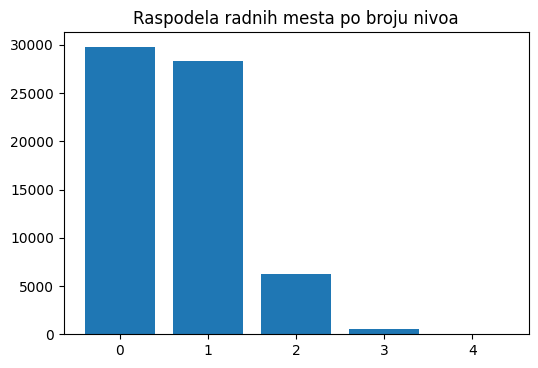

In [15]:
# Predstavljanje raspodele broja nivoa stubićima
plt.bar(*unikati([len(p.levels) for p in podjed]))

# Naslov grafikona
_ = plt.title('Raspodela radnih mesta po broju nivoa')

Kada se izdvoje samo obeležena radna mesta, dakle ona sa makar jednim nivoom, broj od 64.815 različitih spada na 35.006.

In [16]:
# Izdvajanje obeleženih radnih mesta
podobel = [p for p in podjed if p.levels]

# Izveštavanje o ukupom broju instanci
print('Ukupno učitanih radnih mesta:', len(podaci))

# Izveštavanje o broju jedinstvenih instanci
print('Ukupno različitih radnih mesta:', len(podjed))

# Izveštavanje o broju obeleženih instanci
print('Ukupno obeleženih radnih mesta:', len(podobel))

Ukupno učitanih radnih mesta: 611586
Ukupno različitih radnih mesta: 64815
Ukupno obeleženih radnih mesta: 35006


Zanimljivo je videti i koja su to radna mesta sa čak četiri nivoa u nizu. Primetno je da je reč o pozicijama koje su u suštini složene. U svakom slučaju, zadatak je primer [višelabelarne klasifikacije](https://en.wikipedia.org/wiki/Multi-label_classification), što znači da se ne traži tačno jedna oznaka, već njihov (neprazan) skup.

In [17]:
# Sortiranje podataka prema broju nivoa
podobel.sort(key=lambda p: len(p.levels))

# Ispis tri najobeleženija radna mesta
for i in range(-1, -4, -1):
    print(podobel[i])

{
  name: co-founder and chief operations officer and senior vice president legal,
  role: legal,
  levels: ['senior', 'vp', 'owner', 'cxo'],
  sub_role: None
}
{
  name: general manager, chief executive officer, senior vice president, us,
  role: None,
  levels: ['manager', 'senior', 'vp', 'cxo'],
  sub_role: None
}
{
  name: senior vice president, director of business development,
  role: sales,
  levels: ['senior', 'director', 'cxo', 'vp'],
  sub_role: business_development
}


Za kraj analize, korisno je nacrtati raspodelu klasa, kako bi se stekao uvid u balansiranost skupa. Primetno je da je najveći udeo menadžerskih pozicija, dok npr. početničkih ima vrlo malo. Inače, ukupno je deset klasa, što se može videti na priloženom grafikonu sa stubićima: *cxo* (direktor), *director* (upravnik), *entry* (početnik), *manager* (menadžer), *owner* (vlasnik), *partner* (partner), *senior* (senior), *training* (praktikant), *unpaid* (neplaćen/volonter), *vp* (potpredsednik).

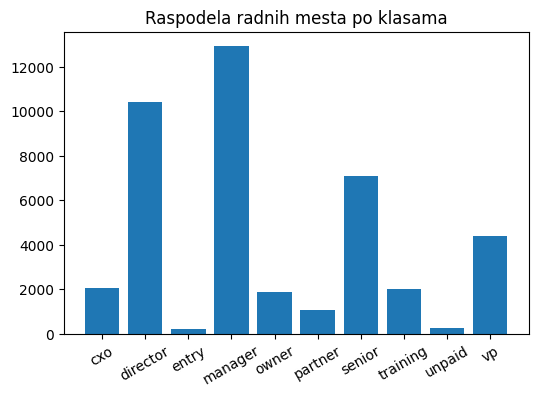

In [18]:
# Crtanje raspodele radnih mesta po klasama
def raspodela(skup):
    # Inicijalno prazan niz klasa
    klase = []

    # Dohvatanje klasa svih radnih mesta
    for p in skup:
        klase.extend(p.levels)

    # Predstavljanje raspodele broja nivoa stubićima
    plt.bar(*unikati(klase))

    # Rotacija naziva kako ne bi bilo preklapanja
    plt.xticks(rotation=30)

    # Naslov grafikona
    _ = plt.title('Raspodela radnih mesta po klasama')

# Raspodela radnih mesta u celom skupu
raspodela(podobel)

## 3. Normalizacija teksta [⮭]<a id="par:norm"></a>

[⮭]: #par:toc

Normalizacija igra značajnu ulogu u klasifikaciji teksta. Poželjno je sve nazive radnih mesta učiniti što uniformnijim. Prvi korak u tome jeste [segmentacija teksta](https://en.wikipedia.org/wiki/Text_segmentation), što se u ovom slučaju svodi na izdvajanje reči i interpunkcije. Ovako izdvojene celine nazivaju se tokeni i mogu se dobiti pomoću modula [*NLTK*](https://www.nltk.org/).

In [19]:
# Modul za rad sa tekstom
import nltk

# Tokenizacija svakog radnom mesta
for p in podobel:
    p.tokeni = nltk.tokenize.word_tokenize(p.name)

In [20]:
# Ispis prvog radnog mesta
print(podobel[0].name)
print(podobel[0].tokeni)

general manager - middle east
['general', 'manager', '-', 'middle', 'east']


In [21]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)

co-founder and chief operations officer and senior vice president legal
['co-founder', 'and', 'chief', 'operations', 'officer', 'and', 'senior', 'vice', 'president', 'legal']


Dalje, dobro je da je svaka reč svedena na neki osnovni oblik. Ovo je moguće uraditi [stemovanjem](https://en.wikipedia.org/wiki/Stemming), što je proces koji heuristički pokušava da dođe do osnove reči. Alternativno, može se precizno pronaći koren (lema, rečnička forma) reči procesom [lematizacije](https://en.wikipedia.org/wiki/Lemmatisation). Oba su izvodljiva u učitanoj biblioteci *NLTK*. Važno je samo napomenuti da lematizator zahteva i vrstu reči kao argument, pa je za te potrebe iskorišćen ugrađeni obeleživač vrste reči ([*POS tagger*](https://en.wikipedia.org/wiki/Part-of-speech_tagging)).

In [22]:
# Modul za rad sa naprednim rečnikom
from collections import defaultdict

# Rečnik koji je podrazumevano imenica
mapa = defaultdict(lambda: nltk.corpus.wordnet.NOUN)

# Popunjavanje ostalih skraćenica
mapa['J'] = nltk.corpus.wordnet.ADJ
mapa['S'] = nltk.corpus.wordnet.ADJ_SAT
mapa['V'] = nltk.corpus.wordnet.VERB
mapa['R'] = nltk.corpus.wordnet.ADV

# Funkcija za tagovanje
tag = lambda j: mapa[j[0]]

# Instanciranje lematizatora
lema = nltk.stem.WordNetLemmatizer()

# Određivanje vrste reči svakog radnog mesta
for p in podobel:
    pos = nltk.pos_tag(p.tokeni)
    
    # Lematizacija svakog tokena
    p.toklem = [lema.lemmatize(i, tag(j)) for i, j in pos]

In [23]:
# Ispis petstotog radnog mesta
print(podobel[499].name)
print(podobel[499].tokeni)
print(podobel[499].toklem)

global customer insights lead
['global', 'customer', 'insights', 'lead']
['global', 'customer', 'insight', 'lead']


In [24]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)
print(podobel[-1].toklem)

co-founder and chief operations officer and senior vice president legal
['co-founder', 'and', 'chief', 'operations', 'officer', 'and', 'senior', 'vice', 'president', 'legal']
['co-founder', 'and', 'chief', 'operation', 'officer', 'and', 'senior', 'vice', 'president', 'legal']


Takođe, dobro je da je u opticaju neki manji skup karaktera, kako bi se dodatno smanjio broj jedinstvenih tokena. Primera radi, to mogu biti [*ASCII*](https://en.wikipedia.org/wiki/ASCII) karakteri, i to samo mala slova engleske latinice i znaci interpunkcije unutar reči (npr. *co-founder*). U redu je obrisati preostalu samostalnu interpunkciju.

In [25]:
# Modul sa posebnim niskama
import string

# Provera da li su sve mala ASCII slova
def aski(t):
    for c in t:
        if c not in string.ascii_lowercase and c not in string.punctuation:
            return False
    return True

# Izbacivanje svega što nisu mala ASCII slova
for p in podobel:
    p.tokpunk = [t for t in p.toklem if t not in string.punctuation and aski(t)]

In [26]:
# Ispis prvog radnog mesta
print(podobel[0].name)
print(podobel[0].tokeni)
print(podobel[0].tokpunk)

general manager - middle east
['general', 'manager', '-', 'middle', 'east']
['general', 'manager', 'middle', 'east']


In [27]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)
print(podobel[-1].tokpunk)

co-founder and chief operations officer and senior vice president legal
['co-founder', 'and', 'chief', 'operations', 'officer', 'and', 'senior', 'vice', 'president', 'legal']
['co-founder', 'and', 'chief', 'operation', 'officer', 'and', 'senior', 'vice', 'president', 'legal']


Za kraj, poželjno je ukloniti i takozvane [stop reči](https://en.wikipedia.org/wiki/Stop_word), za koje se očekuje da ne mogu doprineti klasifikaciji radnih mesta. To su npr. zamenice, veznici i slične leme bez semantike u kontekstu senioriteta. One bi u nastavku bespotrebno opteretile klasifikacione modele, a ne bi doprinele generalizaciji i kvalitetu.

In [28]:
# Dohvatanje stop reči u engleskom jeziku
stop = nltk.corpus.stopwords.words('english')

# Izbacivanje svih stop reči u engleskom jeziku
for p in podobel:
    p.tokstop = [t for t in p.tokpunk if t not in stop]

In [29]:
# Ispis prvog radnog mesta
print(podobel[0].name)
print(podobel[0].tokeni)
print(podobel[0].tokstop)

general manager - middle east
['general', 'manager', '-', 'middle', 'east']
['general', 'manager', 'middle', 'east']


In [30]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)
print(podobel[-1].tokstop)

co-founder and chief operations officer and senior vice president legal
['co-founder', 'and', 'chief', 'operations', 'officer', 'and', 'senior', 'vice', 'president', 'legal']
['co-founder', 'chief', 'operation', 'officer', 'senior', 'vice', 'president', 'legal']


Spajanjem konačnog niza tokena može se dobiti nova tekstualna reprezentacija radnog mesta, čisto kompletnosti radi.

In [31]:
# Spajanje konačnog niza tokena u novo ime
for p in podobel:
    p.newname = ' '.join(p.tokstop)

In [32]:
# Ispis prvog radnog mesta
print(podobel[0].name)
print(podobel[0].newname)

general manager - middle east
general manager middle east


In [33]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].newname)

co-founder and chief operations officer and senior vice president legal
co-founder chief operation officer senior vice president legal


Pre preduzimanja daljih koraka, zanimljivo je grafički predstaviti i raspodelu broja tokena. Ukupno ih je 153.495, ali samo 7903 različita.

In [34]:
# Inicijalno prazan niz tokena
tokeni = []

# Dohvatanje svih tokena
for p in podobel:
    tokeni.extend(p.tokstop)

# Određivanje jedinstvenih tokena
tokjed, brjed = unikati(tokeni)

# Izveštavanje o ukupnom broju tokena
print('Ukupno tokena:', len(tokeni))

# Izveštavanje o broju različitih tokena
print('Različitih tokena:', len(tokjed))

Ukupno tokena: 153495
Različitih tokena: 7903


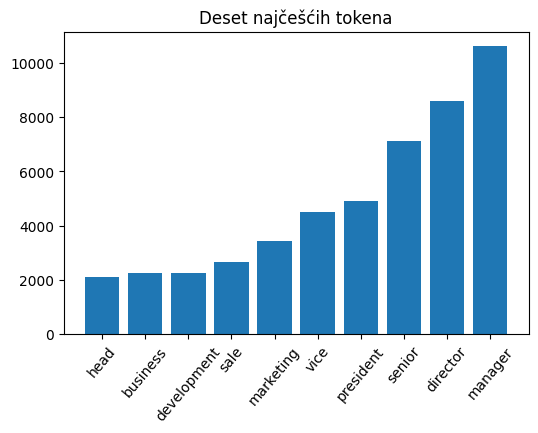

In [35]:
# Indeksi za sortiranje po broju ponavljanja
indeksi = np.argsort(brjed)

# Sortiranje jedinstvenih tokena po broju ponavljanja
tokjed = tokjed[indeksi]
brjed = brjed[indeksi]

# Crtanje deset najčešćih tokena
plt.bar(tokjed[-10:], brjed[-10:])

# Rotacija naziva kako ne bi bilo preklapanja
plt.xticks(rotation=50)

# Naslov grafikona
_ = plt.title('Deset najčešćih tokena')

Značajan je i podataka o tome da li su neki tokeni jedinstveni. Takvih je više od pola i oni nemaju značaja u klasifikaciji zasnovanoj na rečima.

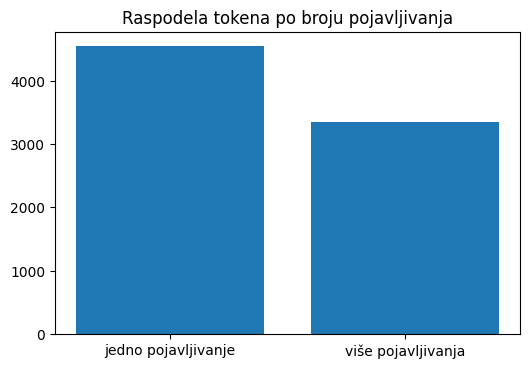

In [36]:
# Određivanje brojeva ponavljanja
_, j = unikati([b > 1 for b in brjed])

# Predstavljanje raspodele stubićima
plt.bar(['jedno pojavljivanje', 'više pojavljivanja'], j)

# Naslov grafikona
_ = plt.title('Raspodela tokena po broju pojavljivanja')

Zanimljivo je nacrtati i raspodelu dužina imena radnih mesta, odnosno broja tokena u konačnom lematizovanom i pročišćenom nizu.

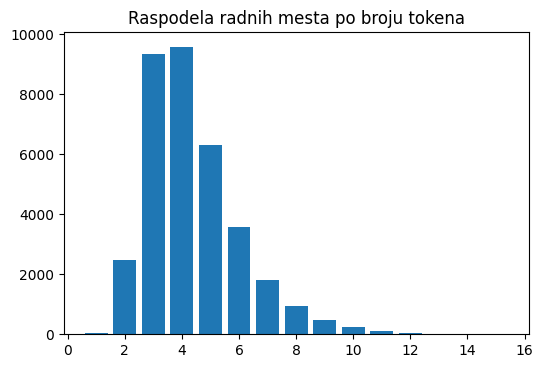

In [37]:
# Inicijalno prazan niz dužina
lens = []

# Dohvatanje svih tokena
for p in podobel:
    lens.append(len(p.tokstop))

# Predstavljanje raspodele dužine stubićima
plt.bar(*unikati(lens))

# Naslov grafikona
_ = plt.title('Raspodela radnih mesta po broju tokena')

## 4. Klasifikaciona pravila [⮭]<a id="par:prav"></a>

[⮭]: #par:toc

Imena su sada normalizovana. To, međutim, nije dovoljno kako bi bila prosleđena klasifikacionim modelima na obučavanje. Problem je što modeli mahom ne prihvataju tekst (niske) ili nizove tokena, već isključivo reprezentaciju u vidu vektora fiksne dužine. To znači da je imena neophodno vektorizovati.

Postavlja se pitanje kako od teksta napraviti vektor. Ideja se može pronaći u simboličkom *NLP*-ju, kao prvoj etapi razvoja obrade prirodnih jezika. On zagovara upotrebu [klasifikacionih pravila](https://en.wikipedia.org/wiki/Classification_rule), koja direktno rade nad tekstom ili nizom tokena. Npr. može se pretpostaviti da svako ime koje sadrži reč *manager* predstavlja jednog menadžera (klasa *manager*), dok svaki potpredsednik (klasa *vp*) sadrži reč *vice*. Ovakva [pravila pridruživanja](https://en.wikipedia.org/wiki/Association_rule_learning) mogu se i automatski pronaći.

Uspešnost pravila ocenjuje se [dvema merama](https://en.wikipedia.org/wiki/Precision_and_recall): odzivom, koji je udeo prepoznatih instanci ciljane klase, i preciznošću, koja je udeo tačno prepoznatih.

$$ \text{odziv} = \frac{|\text{dohvaćeni ciljane klase}|}{|\text{svi ciljane klase}|} \; \; \; \; \; \; \text{preciznost} = \frac{|\text{dohvaćeni ciljane klase}|}{|\text{svi dohvaćeni}|} $$

In [38]:
# Funkcija koja ocenjuje predloženo pravilo
def oceni_pravilo(šablon, klasa):
    # Ispis predloženog pravila
    print('Pravilo:', šablon, '→', klasa, end='\n\n')
    
    # Inicijalno prazan niz klasa dohvaćenih instanci
    klase = []
    
    # Dohvatanje svih instanci prema pravilu
    for p in podobel:
        if šablon in p.newname:
            klase.append(klasa in p.levels)
    
    # Računanje brojioca i imenilaca mera
    dck = sum(klase)
    sck = sum(klasa in p.levels for p in podobel)
    sd = len(klase)
    
    # Ispis brojioca i imenilaca mera
    print('Dohvaćeni ciljane klase:', dck)
    print('Svi ciljane klase:', sck)
    print('Svi dohvaćeni:', sd, end='\n\n')
    
    # Računanje odziva i preciznosti
    odziv = dck / sck
    preciznost = dck / sd
    
    # Ispis odziva i preciznosti
    print('Odziv pravila:', odziv)
    print('Preciznost pravila:', preciznost, end='\n\n')
    
    # Ispis kontraprimera
    print('Kontraprimeri:')
    
    # Kontraprimer koji smanjuje preciznost
    for p in podobel:
        if šablon in p.newname and klasa not in p.levels:
            print(p.name, p.levels)
            break
    
    # Kontraprimer koji smanjuje odziv
    for p in podobel:
        if šablon not in p.newname and klasa in p.levels:
            print(p.name, p.levels)
            break

In [39]:
# Primer pravila visoke preciznosti
oceni_pravilo('manager', 'manager')

Pravilo: manager → manager

Dohvaćeni ciljane klase: 10375
Svi ciljane klase: 12925
Svi dohvaćeni: 10462

Odziv pravila: 0.8027079303675049
Preciznost pravila: 0.9916841904033645

Kontraprimeri:
senior customer and sales advisor and account manager ['senior']
games 2015 middle east - team lead, main exhibition ['manager']


In [40]:
# Primer pravila visokog odziva
oceni_pravilo('vice', 'vp')

Pravilo: vice → vp

Dohvaćeni ciljane klase: 4376
Svi ciljane klase: 4386
Svi dohvaćeni: 5765

Odziv pravila: 0.9977200182398541
Preciznost pravila: 0.7590633130962706

Kontraprimeri:
general manager - australian sales and service ['manager']
mergers and acquisitions investment banking, seed investing ['vp']


In [41]:
# Primer skoro savršenog pravila
oceni_pravilo('senior', 'senior')

Pravilo: senior → senior

Dohvaćeni ciljane klase: 7067
Svi ciljane klase: 7075
Svi dohvaćeni: 7073

Odziv pravila: 0.99886925795053
Preciznost pravila: 0.9991517036618125

Kontraprimeri:
glenn myles,senior managing director head of soverign wealth funds ['director']
campaign alliances manager ['senior']


Primetno je da pravila mogu biti vrlo precizna, pa i postići visoki odziv. Ona, međutim, zahtevaju stručnjake koji bi ih pisali i održavali, tako da se uglavnom ne koriste u praksi, osim u posebnim slučajevima ili u kombinaciji sa drugim metodama. Savremeni pristupi zasnovani su na automatskom učenju pravila ili makar njihovoj ugradnji u vektorsku reprezentaciju teksta koji se klasifikuje. Pravila, dakle, mogu biti polazna tačka za pravljenje vektora od teksta.

Ugradnja pravila u vektorsku reprezentaciju teksta može biti ručna, tako što se svojstva (karakteristike, [*features*](https://en.wikipedia.org/wiki/Feature_%28machine_learning%29)) izgrađuju na osnovu predefinisanih šablona. Prema prethodnim pravilima, mogla bi se [napraviti](https://en.wikipedia.org/wiki/Feature_engineering) istinitosna svojstva `sadrži(manager)` i `sadrži(senior)` koja bi bila `True` (`1`) za imena koja sadrže reči (tokene, podniske) *manager*, odnosno *vice*, a `False` (`0`) za ostale instance. Slično se mogu napraviti i druga ručno smišljena važna svojstva (detalji se mogu videti [ovde](https://towardsdatascience.com/job-title-analysis-in-python-and-nltk-8c7ba4fe4ec6)), npr. ona koja pamte prvu i poslednju reč ili broj tokena. Ovakve karakteristike uglavnom su diskretne, mada to ne mora biti slučaj.

## 5. Retka vektorizacija [⮭]<a id="par:retk"></a>

[⮭]: #par:toc

Prethodno pomenuti način vektorizacije teksta gradi takozvane retke reprezentacije. To znači da u njima velika većina karakteristika ima vrednost `False` (`0`), a tek poneka `True` (`1`). Osim toga, broj svojstava je često veoma veliki, što otežava obučavanje modela. Ipak, ovakve reprezentacije teksta su vrlo korišćene i uspešne. U stvarnosti, međutim, ne grade se ručno, već se koriste različiti vektorizatori, koji izgrađuju različite vrste retkih reprezentacija. Vektorizatori grade kostur reprezentacije na osnovu skupa za obučavanje, pa je za početak neophodno podeliti pripremljeni skup radnih mesta.

In [42]:
# Modul za podelu na skup za obučavanje i proveru
from sklearn.model_selection import train_test_split

# Podela podataka na dva odvojena dela
train, test = train_test_split(podobel, random_state=0)

# Ispis broja instanci u odvojenim delovima
print('Radnih mesta u skupu za obučavanje:', len(train))
print('Radnih mesta u skupu za proveru:', len(test))

Radnih mesta u skupu za obučavanje: 26254
Radnih mesta u skupu za proveru: 8752


Značajno je utvrditi da nije došlo do poremećaja raspodele klasa nakon podele, odnosno da je raspodela na skupu za obučavanje i proveru identična.

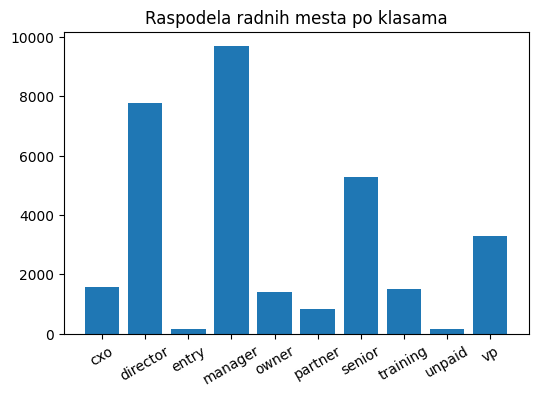

In [43]:
# Raspodela radnih mesta u trening skupu
raspodela(train)

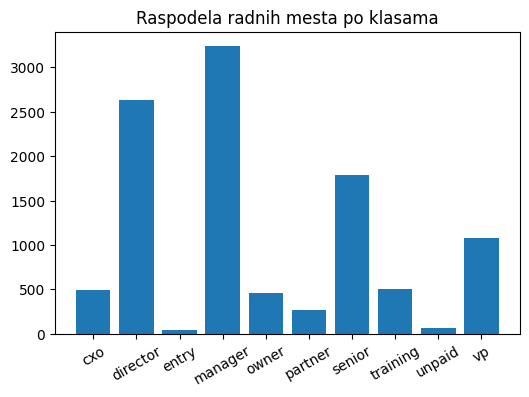

In [44]:
# Raspodela radnih mesta u test skupu
raspodela(test)

Poznata vrsta reprezetancije jesu [*n*-gramski](https://en.wikipedia.org/wiki/N-gram) modeli. Naime, mogu se posmatrati sve moguće susedne *n*-torke nekih jedinica (reči, karaktera ili čak bajtova) koji postoje, pri čemu svaka *n*-torka predstavlja jedno svojstvo. Ovakvi modeli daju dobre rezultate u pojedinim primenama, kao što je određivanje jezika na kom je tekst napisan. Dobra strana im je što što uzimaju u obzir raspored jedinica, ali dobijeni vektori, s druge strane, mogu biti preveliki i previše retki.

<img src="../slike/n-gram.png" alt="Ilustracija n-gramskih modela" width="55%"/>

*N*-gramski modeli sa velikom vrednošću parametra *n* i/ili sa sitnim jedinicama (karakterima ili bajtovima) ipak se nešto ređe koriste. Umesto njih, u upotrebi je [vreća reči](https://en.wikipedia.org/wiki/Bag-of-words_model), koja odgovara unigramskom (*n*-gramskom za $n = 1$) modelu nad rečima. Tekst se u ovom modelu predstavlja vektorom kod koga je svako svojstvo jedna reč iz rečnika, a njegova vrednost zavisi od pojavljivanja te reči u tekstu. Ukoliko se reč ne pojavljuje, vrednost vektora na tom mestu je `0` ili `False`, dok je u suprotnom `1` ili `True` ili pak tačan broj pojavljivanja (nenegativan ceo broj). Ovaj model efektivno zanemaruje položaj i odnose reči u tekstu. Može se primetiti da ovaj princip umnogome odgovara već predstavljenom izdvajanju svojstava na osnovu pravila, odnosno prefedefinisanih šablona.

<img src="../slike/bow.png" alt="Ilustracija vreće reči" width="55%"/>

In [45]:
# Modul za rad sa vrećom reći
from sklearn.feature_extraction.text import CountVectorizer

# Instanciranje vektorizatora
bow = CountVectorizer(min_df=3, binary=True)

# Obučavanje na skupu za trening
_ = bow.fit([p.newname for p in train])

In [46]:
# Ispis naučenih svojstava
print(len(bow.get_feature_names_out()),
      bow.get_feature_names_out())

1889 ['aadvantage' 'ab' 'abm' ... 'zonal' 'zone' 'zynga']


In [47]:
# Ispis kodiranja prve instance
print(bow.transform([train[0].newname]))

  (0, 842)	1
  (0, 981)	1
  (0, 1430)	1
  (0, 1465)	1


Pored binarnog predstavljanja ili tačnog broja pojavljivanja (frekvencije) reči, često se koristi i takozvana [*tf-idf*](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (*term frequency–inverse document frequency*) frekvencija, koja bi se na srpskom mogla nazvati merom *fa-ifd* (frekvencija atributa, inverzna frekvencija dokumenta). Ova statistika svedoči o značaju reči umesto o prostom broju pojavljivanja. Direktno je srazmerna broju pojavljivanja reči u datom dokumentu za koji se izračunava, a obrnuto srazmerna ukupnom broju dokumenata koji sadrže tu reč. Tako su otežane česte reči u nekom tekstu, ali su olakšane one koje se nalaze u mnogim različitim tekstovima.

<img src="../slike/tf-idf.jpeg" alt="Ilustracija tf-idf frekvencije" width="55%"/>

In [48]:
# Modul za rad sa tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Instanciranje vektorizatora
tfidf = TfidfVectorizer(min_df=3)

# Obučavanje na skupu za trening
_ = tfidf.fit([p.newname for p in train])

In [49]:
# Ispis naučenih svojstava
print(len(tfidf.get_feature_names_out()),
      tfidf.get_feature_names_out())

1889 ['aadvantage' 'ab' 'abm' ... 'zonal' 'zone' 'zynga']


In [50]:
# Ispis kodiranja prve instance
print(tfidf.transform([train[0].newname]))

  (0, 1465)	0.5102092564825814
  (0, 1430)	0.5011010757721288
  (0, 981)	0.47808558955208313
  (0, 842)	0.5099199893337616


## 6. Gusta vektorizacija [⮭]<a id="par:gust"></a>

[⮭]: #par:toc

Upotreba retkih reprezentacija uz metode mašinskog učenja odlika je statističkog *NLP*-ja, kao druge etape razvoja obrade prirodnih jezika. U aktuelnoj, trećoj etapi, fokus je na dubokom učenju i gustim reprezentacijama. Za razliku od dosad razmatranih vektora, koji su izrazito dugački (na konkretnom primeru: 1889, po jedan atribut za svaku različitu reč u trening skupu), ali retki (na konkretnom primeru: najviše desetak nenula vrednosti), nove reprezentacije imaju znatno manji broj karakteristika realnog tipa, pri čemu nijedna nije nula. Osmišljeni su tako da su [kosinusno](https://en.wikipedia.org/wiki/Cosine_similarity) sličniji vektori koji opisuju tekstove iz istih klasa.

<img src="../slike/cosine.png" alt="Ilustracija kosinusne sličnosti" width="55%"/>

Veliki je broj gustih modela, kao što su [*Word2Vec*](https://en.wikipedia.org/wiki/Word2vec), [*GloVe*](https://en.wikipedia.org/wiki/GloVe), [*fastText*](https://en.wikipedia.org/wiki/FastText) ili [*ELMo*](https://en.wikipedia.org/wiki/ELMo). Ovakvi modeli, međutim, mahom rade nad rečima umesto nad tekstom uopšteno ili su zahtevni (hardverski i vremenski) za rad. Poznati laganiji modeli koji vektorizuju ceo tekst jesu [*BERT*](https://en.wikipedia.org/wiki/BERT_%28language_model%29) (*DistilBERT*, [*Sent2Vec*](https://pypi.org/project/sent2vec/)) i [*Doc2Vec*](https://radimrehurek.com/gensim/models/doc2vec.html).